# Capstone Project

Reuben Hough

In [1]:
# Importing Libraries
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import pandas.util.testing as tm
from pandas import DataFrame
from pandas.plotting import register_matplotlib_converters
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
import os
%matplotlib inline
import sys
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import sklearn.preprocessing
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import mean_squared_error
from sklearn.metrics import roc_curve, auc
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import RidgeClassifier, LogisticRegression
from numpy import random
import datetime as dt
from datetime import timedelta
from dateutil.relativedelta import relativedelta
import statsmodels.api as sm
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX as SX
from statsmodels.tsa.seasonal import seasonal_decompose as decomp
from statsmodels.tsa.stattools import adfuller
import itertools
register_matplotlib_converters()
from time import time
import math
from fbprophet import Prophet

In [2]:
Fielder = pd.read_csv('FielderStats.csv')
Pitcher = pd.read_csv('PitcherStats.csv')

In [3]:
FC = Fielder.columns.tolist()[1:]
PC = Pitcher.columns.tolist()[1:]

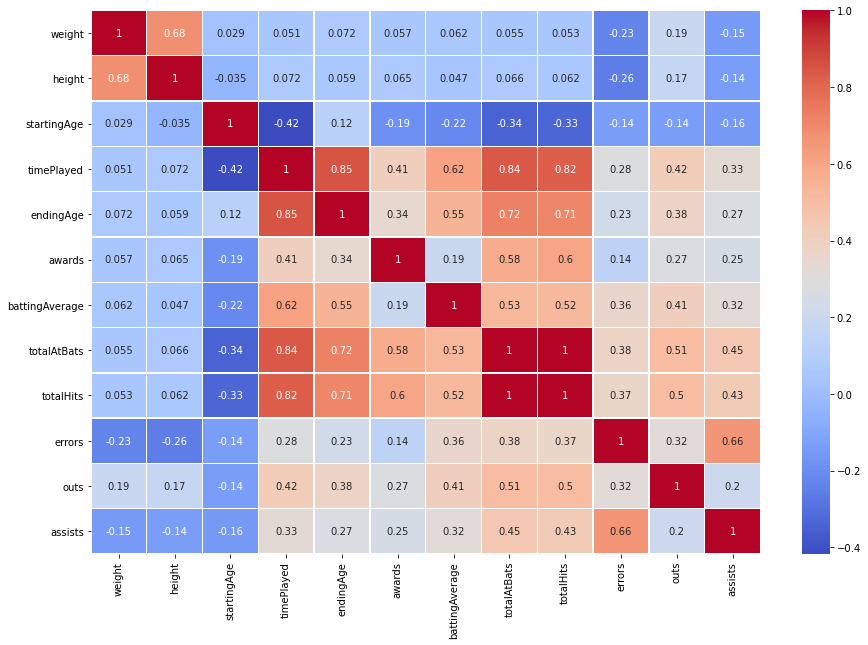

In [4]:
fig, ax = plt.subplots(figsize=(15,10))
sns.heatmap(Fielder[FC].corr(), cmap='coolwarm', annot=True, linewidths=.5, ax=ax);

In [5]:
# Getting rid of heavily correlated columns
Fielder.drop(['timePlayed', 'totalAtBats'], axis=1, inplace=True)

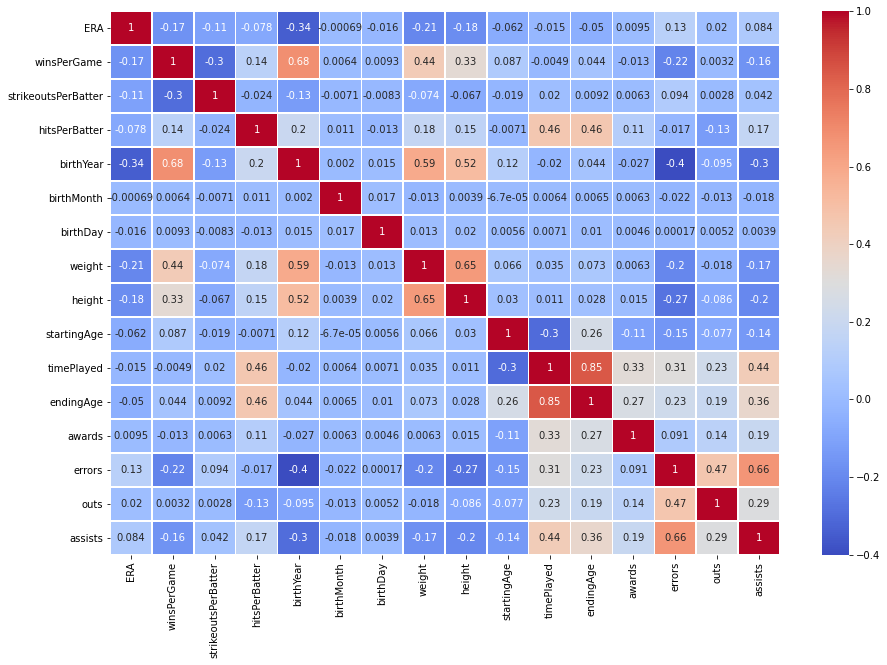

In [6]:
fig, ax = plt.subplots(figsize=(15,10))
sns.heatmap(Pitcher[PC].corr(), cmap='coolwarm', annot=True, linewidths=.5, ax=ax);

In [7]:
Pitcher.drop(['timePlayed', 'birthYear', 'birthMonth','birthDay'], axis=1, inplace=True)

In [8]:
# The awards column works out very well, giving me about a tenth of each
# that I know should be relatively good players. I can also see if their stats will predict
# whether they received awards or not
Pitcher2 = Pitcher.copy()
Pitcher2['awards'] = Pitcher2['awards'].where(Pitcher2['awards'] > 0.2, np.NaN)
Pitcher2.dropna()

,playerID,ERA,winsPerGame,strikeoutsPerBatter,hitsPerBatter,weight,height,startingAge,endingAge,awards,errors,outs,assists
7,abbotji01,0.179545,0.152182,0.240909,23.909091,200.0,75.0,21.58,31.83,2.0,0.818182,6.545455,27.272727
13,abernte02,0.142941,0.129824,0.236000,40.058824,215.0,76.0,22.08,39.50,2.0,1.235294,5.411765,17.882353
38,adamsba01,0.272947,0.062368,0.246579,25.368421,185.0,71.0,23.92,44.25,2.0,0.894737,3.052632,34.105263
68,ainsmed01,0.000000,0.333000,0.667000,1.000000,180.0,71.0,20.50,34.42,1.0,9.650000,220.500000,54.400000
72,akerja01,0.175714,0.180143,0.242571,35.357143,190.0,74.0,23.83,34.17,1.0,0.571429,4.642857,11.928571
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9417,zachrpa01,0.166455,0.138545,0.208091,26.636364,180.0,77.0,24.00,33.08,1.0,1.181818,5.454545,16.000000
9420,zahnge01,0.145643,0.118571,0.245643,21.714286,180.0,73.0,27.75,39.67,1.0,1.714286,6.214286,23.285714
9422,zambrca01,0.082417,0.158833,0.259417,29.500000,275.0,76.0,20.17,31.25,3.0,2.083333,14.000000,24.166667
9451,zitoba01,0.121400,0.152133,0.256467,28.866667,205.0,74.0,22.17,37.33,4.0,1.000000,5.733333,21.466667


In [9]:
# the train sections need to be cut down some to get better results
Fielder2 = Fielder.copy()
Fielder2['errors'] = Fielder2['errors'].where(Fielder2['errors'] < 40, np.NaN)
Fielder2['assists'] = Fielder2['assists'].where(Fielder2['assists'] > 2, np.NaN)
Fielder2['battingAverage'] = Fielder2['battingAverage'].where(Fielder2['battingAverage'] !=0, np.NaN)
Fielder2 = Fielder2.dropna()

In [10]:
Pitcher2 = Pitcher.copy()
Pitcher2['ERA'] = Pitcher2['ERA'].where(Pitcher2['ERA'] !=0, np.NaN)
Pitcher2['ERA'] = Pitcher2['ERA'].where(Pitcher2['ERA'] <= 0.4, np.NaN)
Pitcher2['hitsPerBatter'] = Pitcher2['hitsPerBatter'].where(Pitcher2['hitsPerBatter'] >=15, np.NaN)
Pitcher2['winsPerGame'] = Pitcher2['winsPerGame'].where(Pitcher2['winsPerGame'] >=0.09, np.NaN)
Pitcher2['outs'] = Pitcher2['outs'].where(Pitcher2['outs'] >=5, np.NaN)
Pitcher2['errors'] = Pitcher2['errors'].where(Pitcher2['errors'] >=.3, np.NaN)
Pitcher2 = Pitcher2.dropna()

In [11]:
Pitcher3 = Pitcher.copy()
Pitcher3['awards'] = Pitcher3['awards'].where(Pitcher3['awards'] < 0.2, 1)
P3 = Pitcher3['awards'].value_counts()
print((P3[0])/(P3[1]))
Pitcher4 = Pitcher2.copy()
Pitcher4['awards'] = Pitcher4['awards'].where(Pitcher4['awards'] < 0.2, 1)
P4 = Pitcher4['awards'].value_counts()
print((P4[0])/(P4[1]))

16.914772727272727
3.805084745762712


In [12]:
Fielder2['awards'] = Fielder2['awards'].where(Fielder2['awards'] < 1.2, 2)
Fielder2['awards'].value_counts()

0    4711
2     592
1     236
Name: awards, dtype: int64

In [13]:
Pitcher2['awards'] = Pitcher2['awards'].where(Pitcher2['awards'] < 1.2, 2)
Pitcher2['awards'].value_counts()

0    898
2    157
1     79
Name: awards, dtype: int64

Here I made any more than one award equal to two, to simplify categories, and to try and prevent the classifiers from putting all into the no award category.

## Testing Pitchers

In [14]:
def TestTrain(df):
    y = df['awards']
    x = df.drop(['awards', 'playerID'], axis=1)
    x_train,x_test,y_train,y_test = train_test_split(x,y)
    w = x_train,x_test,y_train,y_test
    return w

In [15]:
# Using several classifiers to test the data
classifiers = [RidgeClassifier(),KNeighborsClassifier(),
               RandomForestClassifier(),AdaBoostClassifier(),
               DecisionTreeClassifier(), LogisticRegression()]
classifiernames = ['Ridge','KNN',"Random Forest","Adaboost","Decision Tree", "Logistic"]

In [16]:
# Prints accuracy of classification method,
# and provides a visual confusion matrix
def statistics(clf, w):
    print(clf)
    clf.fit(w[0], w[2])
    pred = clf.predict(w[1])
    score = metrics.accuracy_score(w[3], pred)
    print("accuracy:   %0.3f" % score)
    matrix = metrics.confusion_matrix(w[3], pred)
    print()
    clf_descr = str(clf).split('(')[0]
    return clf_descr, score, matrix

In [17]:
results = []
for clf in classifiers:
    results.append(statistics(clf, TestTrain(Pitcher2)))

RidgeClassifier()
accuracy:   0.820

KNeighborsClassifier()
accuracy:   0.835

RandomForestClassifier()
accuracy:   0.796

AdaBoostClassifier()
accuracy:   0.785

DecisionTreeClassifier()
accuracy:   0.711

LogisticRegression()
accuracy:   0.824



## Testing Fielders

In [18]:
def Matrix(results, x, name):
    cm = pd.DataFrame(results[x][2], index = [i for i in [0,1,2]],
                  columns = [i for i in [0,1,2]])
    plt.figure(figsize = (10,7))
    plt.title(name[x])
    sns.heatmap(cm, annot=True)

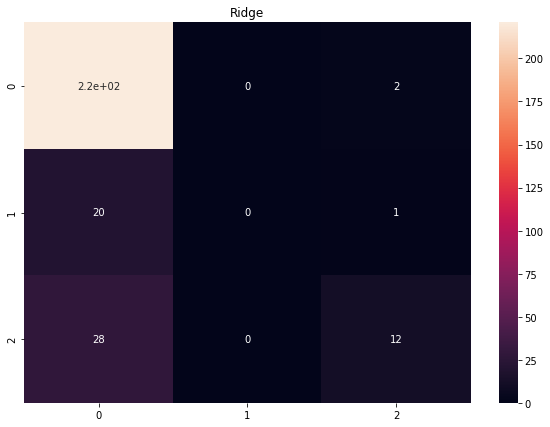

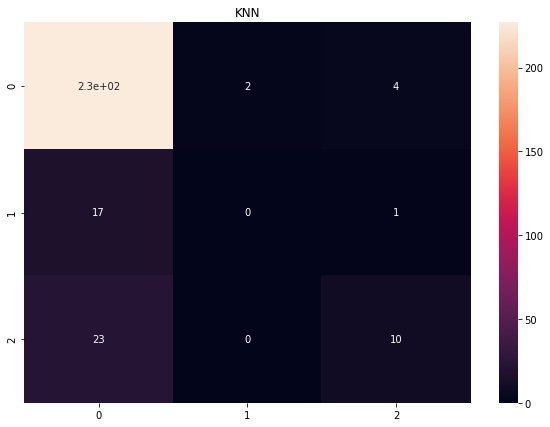

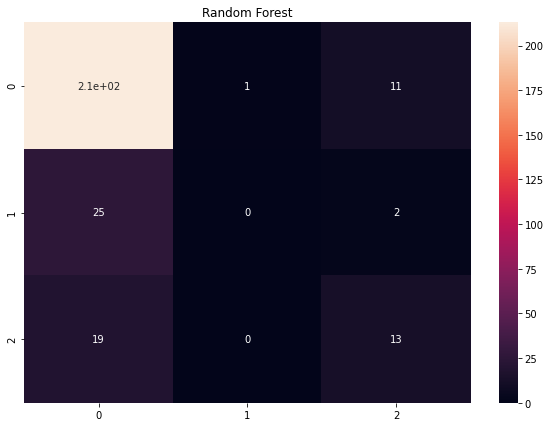

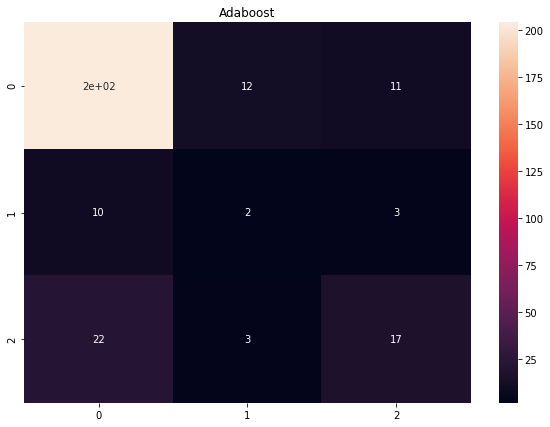

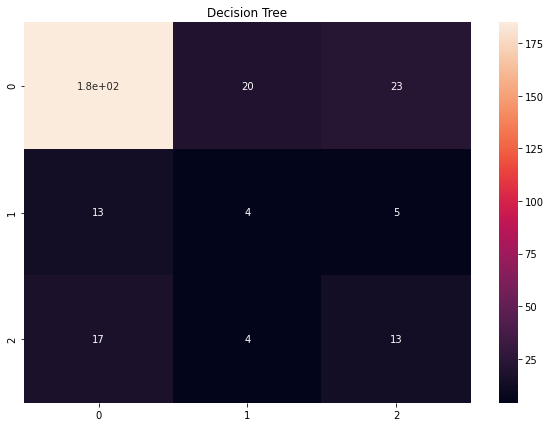

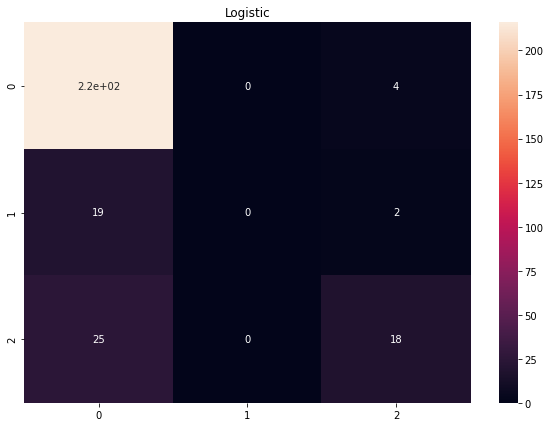

In [19]:
indices = np.arange(len(results))
for x in indices:
    Matrix(results, x, classifiernames)

In [20]:
results = []
for clf in classifiers:
    results.append(statistics(clf, TestTrain(Fielder2)))

RidgeClassifier()
accuracy:   0.900

KNeighborsClassifier()
accuracy:   0.891

RandomForestClassifier()
accuracy:   0.898

AdaBoostClassifier()
accuracy:   0.895

DecisionTreeClassifier()
accuracy:   0.852

LogisticRegression()
accuracy:   0.891



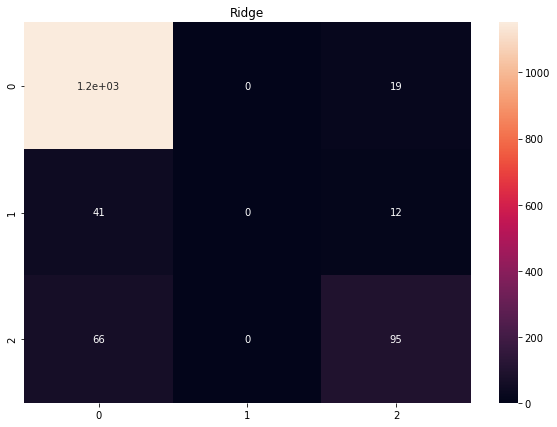

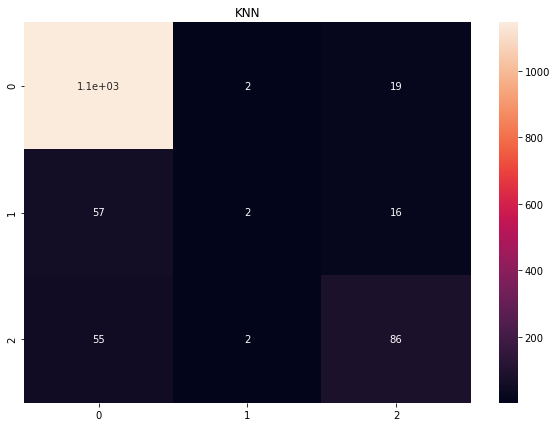

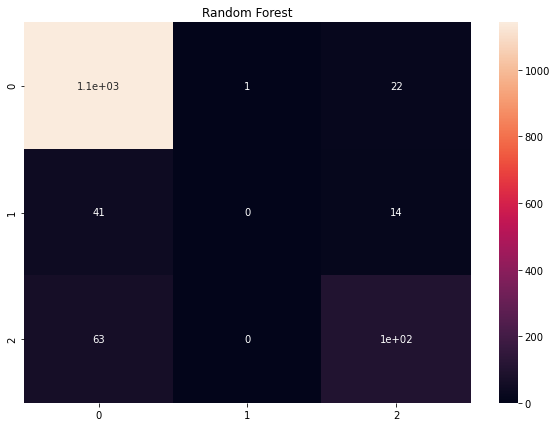

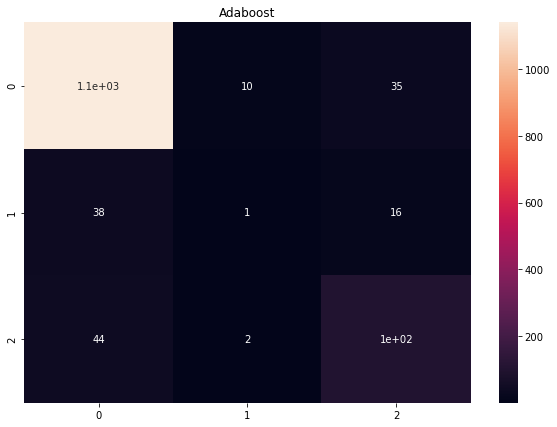

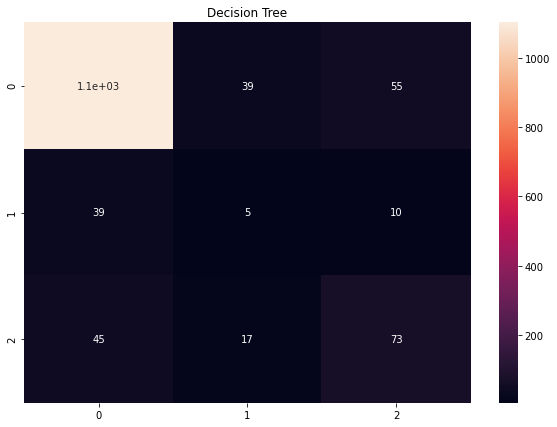

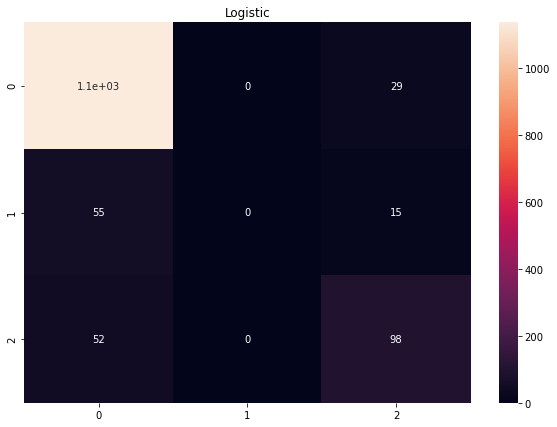

In [21]:
indices = np.arange(len(results))
for x in indices:
    Matrix(results, x, classifiernames)

These are not great results as far as correctly classifying awards. It's possible that awards are somewhat arbitrarily handed out.

NameError: name 'result' is not defined